# 🧠 Multi-Agent Workflows

In the real world, **no single agent can solve every problem optimally**. As tasks grow in **uncertainty, dimensionality, and interdependence** — such as strategy games, simulations, robotics, or real-time business systems — we naturally evolve from *single-agent* reasoning to **multi-agent workflows**.

These workflows mirror how humans collaborate:

* 🗳️ **Democratic committees** balance diverse perspectives.
* 🧭 **Hierarchical managers** coordinate specialists under limited resources.
* ⚖️ **Actor-Critic systems** separate exploration (actor) from judgment (critic).

Each pattern encodes a different *philosophy of coordination* — distributing intelligence across specialized roles that communicate, negotiate, and arbitrate toward a shared goal.


### ⚙️ What Are Multi-Agent Workflows?

A **multi-agent workflow** is a structured network of reasoning and action nodes — planners, evaluators, arbiters, memory modules — that interact through explicit channels rather than a single monolithic prompt.

Think of it as a **graph of decision-making** where:

* Nodes = agents (LLMs, heuristics, or functions).
* Edges = communication or dependency between them.
* Memory = shared context that persists across steps.
* Arbitration = how conflicting opinions are resolved.

This structure enables:

* **Parallel specialization** (multiple evaluators in parallel).
* **Conditional routing** (managers deciding who to consult).
* **Resource budgeting** (decide when to skip expensive reasoning).
* **Explainability & debugging** (explicit traces of who decided what).


### 🧩 Enter [Pydantic Graphs](https://ai.pydantic.dev/graph/)

Building and managing these interactions manually is painful — tracking state, type safety, branching, and parallel execution can get messy fast.

[Pydantic Graphs](https://ai.pydantic.dev/graph/) solves this elegantly by combining:

* ✅ **Typed data flow** from Pydantic models — ensuring every node’s input and output are structured, validated, and traceable.
* 🕸️ **Graph orchestration** — defining agents and their dependencies as composable, inspectable workflows.
* 🔁 **Parallel & conditional execution** — automatically handling fan-out (multiple evaluators) and routing logic (manager/critic decisions).
* 🧾 **Transparent traces** — every step’s inputs, outputs, and reasoning can be logged, visualized, and replayed.

Together, they turn the messy spaghetti of agent calls into a **declarative decision graph** — a scalable foundation for complex, memory-aware, multi-agent systems.

### 🧩 What is `poke-env`?

[`poke-env`](https://poke-env.readthedocs.io/en/stable/) is a **Python interface to the Pokémon Showdown battle simulator**, providing an environment for reinforcement learning and AI experiments.
It exposes each battle as a structured API — giving access to game state (Pokémon, moves, types, HP, etc.) and allowing agents to pick legal actions programmatically.

In our workflow, we’ll use **`poke-env` as the testbed** to:

* ⚔️ **Pit different multi-agent strategies** (democratic, manager, actor-critic) against each other.
* 📊 **Compare performance** through metrics like win rate, turns survived, and move efficiency.
* 🧠 **Benchmark reasoning styles** — seeing how coordination strategies translate into competitive outcomes.

Before running experiments, we’ll start a local Pokémon Showdown server instance. This spins up a self-contained battle environment where our agents can safely train, plan, and battle — making Pokémon the perfect arena for testing *agentic intelligence in action*.

In [1]:
from src.pokemon_showdown_setup import run_pokemon_showdown

pokemon_container = run_pokemon_showdown()

🟢 Container already running: pokemon-showdown (4a670e8e0ee1)



### 🧪 Getting Started with `poke-env`

Before building our custom multi-agent workflows, let’s first understand how the **`poke-env`** battle environment works.
It allows us to easily simulate Pokémon battles between automated agents — here, we’ll start with two simple **`RandomPlayer`** agents that pick legal moves at random.

By running a quick **cross-evaluation**, we can see how `poke-env` orchestrates matches, tracks results, and reports win rates — forming the foundation on which our more sophisticated, reasoning-based agents will later compete.

In [2]:
from poke_env.player.player import Player
from poke_env import RandomPlayer, cross_evaluate

from tabulate import tabulate

first_player = RandomPlayer()
second_player = RandomPlayer()

players = [first_player, second_player]

async def test_cross_evaluation(players, n_challenges=5):
    cross_evaluation = await cross_evaluate(players, n_challenges=n_challenges)

    table = [["-"] + [p.username for p in players]]
    for p_1, results in cross_evaluation.items():
        table.append([p_1] + [cross_evaluation[p_1][p_2] for p_2 in results])

    return tabulate(table)

print(await test_cross_evaluation(players))

--------------  --------------  --------------
-               RandomPlayer 1  RandomPlayer 2
RandomPlayer 1                  0.6
RandomPlayer 2  0.4
--------------  --------------  --------------


Let's see an example battle in action. 

<iframe src="https://shreshthtuli.github.io/build-your-own-super-agents/assets/random_battle.html" width="100%" height="450" style="border:none; overflow:hidden;"></iframe>

*You can also view the full battle [here](https://shreshthtuli.github.io/build-your-own-super-agents/assets/random_battle.html).*

### ⚡ Creating a “Max Damage” Baseline

To add another simple benchmark beyond the `RandomPlayer`, we’ll define a **`MaxDamagePlayer`** — an agent that always selects the move with the highest base power.

This gives us a more *deterministic and aggressive* baseline that prioritizes raw damage output over safety or strategy.
By comparing our Pydantic AI agent against both **Random** and **MaxDamage** players, we can see whether reasoning and memory-aware planning lead to better decision-making than brute-force move selection.


In [3]:
class MaxDamagePlayer(Player):
    def choose_move(self, battle):
        if battle.available_moves:
            best_move = max(battle.available_moves, key=lambda move: move.base_power)

            if battle.can_tera:
                return self.create_order(best_move, terastallize=True)

            return self.create_order(best_move)
        else:
            return self.choose_random_move(battle)
        
players = [first_player, MaxDamagePlayer()]

print(await test_cross_evaluation(players))

-----------------  --------------  -----------------
-                  RandomPlayer 1  MaxDamagePlayer 1
RandomPlayer 1                     0.0
MaxDamagePlayer 1  1.0
-----------------  --------------  -----------------


### 🎮 Pokémon battle mechanics — and how we encode them for our agents

Let's now build a simple agent to do the same, as in, use the battle context to choose the optimal action. 

**Core mechanics (what the agent must reason about):**

* **Turn-based actions:** Each turn you either **use a move** or **switch**. Faster Pokémon usually act first; **priority** can override speed.
* **Types & STAB:** Moves have types (e.g., *Electric*). Effectiveness depends on attacker vs defender types; using a move matching the user’s type grants **STAB** (bonus damage).
* **Accuracy & PP:** Moves can **miss** (accuracy < 100) and have limited **PP** (uses).
* **HP & fainting:** A Pokémon faints at 0 HP; win condition is **faint all opponent Pokémon**.
* **Information limits:** You only know the opponent’s **revealed** Pokémon and partial info about their sets.
* **Switching & tempo:** Switching preserves a weakened Pokémon, but concedes tempo (opponent gets a “free” hit).
* **Status/hazards/weather (omitted here for brevity):** These exist in the simulator; we can add them later as fields.

### 🧱 Our context schema (how we feed the LLM the game state)

We transform poke-env’s `Battle` into a **typed, LLM-friendly snapshot**:

* `TeamMon`: one entry per Pokémon (both sides) with:

  * `species`, fractional `hp`, `fainted`, and `types`.
* `MoveOption`: one entry per **legal move this turn** with:

  * `move_id`, `base_power`, `accuracy`, `move_type`, `pp`, `priority`.
* `SwitchOption`: one entry per **legal switch target** with:

  * `species`, `hp`, `fainted`, `types`.
* `AgentContext`: the full **decision frame** the agent sees:

  * `turn`: current turn number.
  * `you_active` / `opp_active`: currently active Pokémon on both sides.
  * `you_team`: your full team (known).
  * `opp_known`: only **revealed** opponent Pokémon (respecting partial observability).
  * `legal_moves` / `legal_switches`: the **only actions you may take now**.
  * `past_actions`: a short **episodic memory** string list (e.g., summaries of last turns).


### 🛠️ How the code builds this context

* `_pokemon_to_teammon(p)` safely converts a poke-env `Pokemon` into our `TeamMon` schema (species, hp%, types).
* In `build_context(battle, past_actions)`:

  * We iterate `battle.available_moves` to populate `MoveOption` (capturing **damage proxies** via base power, **reliability** via accuracy, **tempo** via priority, and **resource** via PP).
  * We iterate `battle.available_switches` to populate `SwitchOption` (capturing **survivability** options).
  * We map your full `battle.team` into `you_team` and the opponent’s **revealed** team into `opp_known` (partial info).
  * We capture actives (`you_active`, `opp_active`) and the `turn` counter.
  * We attach `past_actions` so the LLM can reason with **short-term memory**.
* `agent_context_to_string(ctx)` serializes the `AgentContext` to **pretty JSON**, ideal for prompting an LLM agent.

**Result:** every decision step provides a **compact, validated, and complete** view of what matters **now**, aligning game mechanics with agent reasoning (damage, risk, tempo, information, and legal constraints).


In [4]:
from __future__ import annotations
from typing import List, Optional, Dict, Any, Literal
from dataclasses import dataclass

from pydantic import BaseModel, Field
from pydantic_ai import Agent

from poke_env.battle.battle import Battle, Pokemon

class TeamMon(BaseModel):
    species: str
    hp: Optional[float] = None
    fainted: bool = False
    types: List[str] = []

class MoveOption(BaseModel):
    move_id: str
    base_power: Optional[int] = None
    accuracy: Optional[float] = None
    move_type: Optional[str] = None
    pp: Optional[int] = None
    priority: int = 0

class SwitchOption(BaseModel):
    species: str
    hp: Optional[float] = None
    fainted: bool = False
    types: List[str] = []

class AgentContext(BaseModel):
    turn: int
    # You
    you_active: Optional[str]
    you_team: List[TeamMon]
    # Opponent
    opp_active: Optional[str]
    opp_known: List[TeamMon]
    # Legals
    legal_moves: List[MoveOption]
    legal_switches: List[SwitchOption]
    # Short episodic memory (last few actions / summaries)
    past_actions: List[str] = []

def _pokemon_to_teammon(p: Pokemon) -> TeamMon:
    if p is None:
        return TeamMon(species="Unknown", hp=None, fainted=False, types=[])
    return TeamMon(
        species=p.species,
        hp=p.current_hp_fraction,
        fainted=p.fainted,
        types=[t.name for t in p.types or []],
    )

def build_context(battle: Battle, past_actions: List[str]) -> AgentContext:
    # legal moves
    legal_moves: List[MoveOption] = []
    for m in battle.available_moves:
        legal_moves.append(MoveOption(
            move_id=m.id,
            base_power=m.base_power,
            accuracy=m.accuracy,
            move_type=m.type.name,
            pp=m.current_pp,
            priority=m.priority,
        ))

    # legal switches
    legal_switches: List[SwitchOption] = []
    for p in battle.available_switches:
        legal_switches.append(SwitchOption(
            species=p.species,
            hp=p.current_hp_fraction,
            fainted=p.fainted,
            types=[t.name for t in (p.types or [])],
        ))

    # teams
    your_team = [_pokemon_to_teammon(poke) for poke in battle.team.values()]
    opp_known = [_pokemon_to_teammon(poke) for poke in battle.opponent_team.values() if poke._revealed] # revealed only

    return AgentContext(
        turn=battle.turn,
        you_active=battle.active_pokemon.species,
        you_team=your_team,
        opp_active=battle.opponent_active_pokemon.species,
        opp_known=opp_known,
        legal_moves=legal_moves,
        legal_switches=legal_switches,
        past_actions=past_actions, 
    )

def agent_context_to_string(ctx: AgentContext) -> str:
    return ctx.model_dump_json(indent=2)

### 🤖 A minimal “thinking player”: from context → structured decision → legal action

**Goal:** turn the JSON context we built into a **single legal action** (move or switch) using a typed LLM agent, and keep a tiny episodic memory of what we did.

#### 1) Structured output contract = `Decision`

* We define a **Pydantic schema** that the LLM must fill:

  * `kind`: `"move"` or `"switch"`.
  * `move_id` / `switch_species`: only one is required depending on `kind`.
  * `rationale`: short explanation (useful for logs and later learning).
* This keeps the model honest and makes post-processing trivial.

#### 2) The LLM-powered player = `PydanticLLMPlayer`

* Extends `poke-env`’s `Player`.
* Sets up a **Pydantic AI `Agent`** (`self.battle_agent`) with:

  * A **system prompt** encoding simple policy: prefer **high-accuracy, super-effective** moves; **switch** if danger is high or moves are poor; **never invent illegal actions**.
  * `output_type=Decision` so the model must return a valid, typed object.

#### 3) Decision loop = `choose_move(...)`

1. **Build context**
   `ctx = build_context(battle, past_actions=self._past_actions)`
   → serializes the current game state + short episodic memory.
2. **Call the agent**
   `decision = self.battle_agent.run_sync(agent_context_to_string(ctx)).output`
   → the LLM reads the JSON, returns a validated `Decision`.
3. **Legality mapping**

   * If `kind == "move"`, find the **exact** `move_id` in `battle.available_moves` and `create_order(m)`.
   * If `kind == "switch"`, match `switch_species` in `battle.available_switches` and `create_order(p)`.
   * We **append a human-readable summary** to `_past_actions` for the next turn’s context.
4. **Safety fallback**
   If, for any reason, the decision isn’t legal (should be rare), we **choose a random legal action** so the game continues.

#### 4) Why this works well

* **Typed outputs** remove prompt-engineering brittleness (no regex parsing or guesswork).
* **Context → Decision → Action** is clean, auditable, and easy to extend (plug in evaluators/critics later).
* The **episodic memory** (`_past_actions`) gives the agent short-term continuity across turns without blowing up context size.

In [5]:
from rich import print as rprint
import nest_asyncio
import logfire

logfire.configure()
nest_asyncio.apply()

class Decision(BaseModel):
    kind: Literal["move", "switch"] = Field(description="Choose 'move' or 'switch'.")
    move_id: Optional[str] = Field(default=None, description="Required if kind == 'move'")
    switch_species: Optional[str] = Field(default=None, description="Required if kind == 'switch'")
    rationale: str

class PydanticLLMPlayer(Player):
    def __init__(self, name: str, model: str = "openrouter:openai/gpt-4o-mini", **kwargs):
        super().__init__(**kwargs)
        self.name = name
        self._past_actions: List[str] = []
        self.battle_agent = Agent(
            model=model,
            system_prompt=(
                "You are a Pokémon battle planner. "
                "Given the current battle context, choose ONE legal action. "
                "Prefer high-accuracy, super-effective moves; "
                "switch if active Pokémon risks being KO'd or has no good moves. "
                "Never invent illegal actions."
            ),
            output_type=Decision,
        )

    def choose_move(self, battle: Battle):
        # Build structured context for the agent
        ctx = build_context(battle, past_actions=self._past_actions)
        # Run agent to get decision
        decision = self.battle_agent.run_sync(agent_context_to_string(ctx)).output
        if battle.turn <= 1:
            rprint(f"CONTEXT:", ctx)
            rprint(f"DECISION:", decision)

        # Map Decision → poke-env action
        if decision.kind == "move":
            # find the matching legal move
            for m in battle.available_moves:
                if m.id == decision.move_id:
                    self._past_actions.append(
                        f"T{ctx.turn}: MOVE {decision.move_id} ({ctx.you_active} vs {ctx.opp_active})"
                    )
                    return self.create_order(m)
        elif decision.kind == "switch":
            # find the matching legal switch
            for p in battle.available_switches:
                if p.species == decision.switch_species:
                    self._past_actions.append(
                        f"T{ctx.turn}: SWITCH to {decision.switch_species} (from {ctx.you_active})"
                    )
                    return self.create_order(p)

        # Fallback: if agent suggested an illegal action (shouldn't happen), choose random
        self._past_actions.append(f"T{ctx.turn}: FALLBACK random")
        return self.choose_random_move(battle)


Logfire project URL: ]8;id=15417;https://logfire-eu.pydantic.dev/shreshthtuli/agenticai\https://logfire-eu.pydantic.dev/shreshthtuli/agenticai]8;;\

### ⚔️ Running our first Agentic battle

Now that we’ve built our **LLM-powered Pokémon agent**, it’s time to see it in action!
Here we instantiate the `PydanticLLMPlayer` and let it **battle a `RandomPlayer`** for a single match.

When the battle runs:

1. Each turn, the **`agentic_player`** builds a structured `AgentContext` (game state + short memory).
2. The **LLM agent** reasons over that context and outputs a **typed `Decision`** (`move` or `switch`).
3. The environment executes that decision, updates the game state, and loops until one side faints all opponents.

This quick match serves as a **smoke test** — verifying that our agent can read the environment, reason with context, and select legal actions correctly before we scale up to multi-agent graphs and tournaments.

In [6]:
agentic_player = PydanticLLMPlayer(name="LLM Agent")

await agentic_player.battle_against(RandomPlayer(), n_battles=1)

CONTEXT:
AgentContext(
    turn=1,
    you_active='glimmora',
    you_team=[
        TeamMon(species='glimmora', hp=1.0, fainted=False, types=['ROCK', 'POISON']),
        TeamMon(species='wochien', hp=1.0, fainted=False, types=['DARK', 'GRASS']),
        TeamMon(species='dusknoir', hp=1.0, fainted=False, types=['GHOST']),
        TeamMon(species='reshiram', hp=1.0, fainted=False, types=['DRAGON', 'FIRE']),
        TeamMon(species='cetitan', hp=1.0, fainted=False, types=['ICE']),
        TeamMon(species='swanna', hp=1.0, fainted=False, types=['WATER', 'FLYING'])
    ],
    opp_active='meowstic',
    opp_known=[TeamMon(species='meowstic', hp=1.0, fainted=False, types=['PSYCHIC'])],
    legal_moves=[
        MoveOption(move_id='energyball', base_power=90, accuracy=1.0, move_type='GRASS', pp=16, priority=0),
        MoveOption(move_id='meteorbeam', base_power=120, accuracy=0.9, move_type='ROCK', pp=16, priority=0),
        MoveOption(move_id='earthpower', base_power=90, accuracy=1.0, move_type='GROUND', pp=16, priority=0),
        MoveOption(move_id='sludgewave', base_power=95, accuracy=1.0, move_type='POISON', pp=16, priority=0)
    ],
    legal_switches=[
        SwitchOption(species='wochien', hp=1.0, fainted=False, types=['DARK', 'GRASS']),
        SwitchOption(species='dusknoir', hp=1.0, fainted=False, types=['GHOST']),
        SwitchOption(species='reshiram', hp=1.0, fainted=False, types=['DRAGON', 'FIRE']),
        SwitchOption(species='cetitan', hp=1.0, fainted=False, types=['ICE']),
        SwitchOption(species='swanna', hp=1.0, fainted=False, types=['WATER', 'FLYING'])
    ],
    past_actions=[]
)

DECISION:
Decision(
    kind='switch',
    move_id=None,
    switch_species='wochien',
    rationale="Glimmora is at very low health (1 HP) and is vulnerable to being knocked out by Meowstic's moves. 
Switching to Wochien can provide a safer option while still allowing for a defensive position."
)

### 🕸️ Introducing *Pydantic Graphs* — the foundation for structured multi-agent workflows

So far, our agent acted as a **single decision-maker**: it observed context, reasoned once, and returned a move. But as environments grow in complexity — multiple objectives, conflicting strategies, limited time — we need **many specialized agents** working together.

That’s where **🧩 Pydantic Graphs** come in.


### ⚙️ What are *Pydantic Graphs*?

**Pydantic Graphs** extend the idea of *typed LLM workflows*: instead of chaining prompts manually, you define a **graph of agents** — each node is a typed, callable component (`Agent`, `Tool`, or function), and edges represent how their structured outputs flow into each other.

Each node’s input/output types are enforced by **Pydantic models**, guaranteeing that
✅ every agent receives valid structured data,
✅ workflows are composable, debuggable, and inspectable,
✅ and parallel/conditional execution (“run these 3 evaluators in parallel”) becomes trivial.


### 🤝 Why multi-agent workflows?

Real decision problems rarely have one “best” heuristic — they’re **multi-objective**:

* Tactical reward vs safety (damage vs survivability)
* Short-term payoff vs long-term setup
* Exploration vs exploitation

Multi-agent graphs let you **distribute cognition**:

* Each node/agent handles a sub-skill (planner, tactician, risk, scout).
* Coordination logic (e.g., a manager or arbiter) **fuses** their reasoning.
* Memory and arbitration layers can be swapped independently (for ablations).

This architecture naturally scales to **agentic swarms** — large ensembles of specialized agents that coordinate dynamically, forming emergent intelligence beyond a single model’s scope.


### 🔀 Static vs Dynamic Query Routing

In our earlier “Manager” agent, the routing (which specialists to call) was **static** — we hard-coded: “always call Tactician, call Risk if danger > 0.6, call Scout every 3 turns”.

**Dynamic routing**, enabled by Pydantic Graphs, makes this adaptive:

* Each agent’s outputs (or intermediate metadata like *uncertainty*, *cost*, or *confidence*) can dynamically decide the next edges to traverse.
* If the planner returns low-confidence moves, the graph might automatically trigger the *Risk Officer* or *Critic* path.
* If confidence is high, it can skip extra steps to save latency or tokens.

🧩 **Benefit:** Resource-aware, self-adapting workflows that scale gracefully — the system “thinks harder” only when needed.


### ✏️ Query Rewriting

Another advanced feature is **query rewriting** — when incoming queries or contexts are **transformed before being passed** to downstream agents. In Pokémon terms, before the planner decides, a *context rewriter* might:

* Simplify redundant details (“ignore irrelevant side conditions”), or
* Add derived features (“this move is likely super-effective against Water”).

This lets different specialists receive **domain-specific representations** of the same state, improving efficiency and interpretability.

### 🚀 Why it matters

Together, **dynamic routing** and **query rewriting** turn a static, hand-crafted pipeline into a **living cognitive graph**:

* 💡 *Adaptive*: reasoning depth scales with uncertainty or stakes.
* 🧠 *Modular*: new skills or evaluators can be plugged in as new nodes.
* ⚖️ *Efficient*: token and time budgets are managed intelligently.
* 🔍 *Transparent*: every decision path and intermediate output is traceable.

By using *Pydantic Graphs*, we can finally move from “prompt chains” to **structured, interpretable agentic systems** — the same architectural leap that turns simple agents into full-fledged, cooperative AI swarms.

In [ ]:
from pydantic_graph import BaseNode, End, Graph, GraphRunContext
import json

class PlanCandidate(BaseModel):
    kind: Literal["move", "switch"]
    move_id: Optional[str] = None
    switch_species: Optional[str] = None
    rationale: str

class Plan(BaseModel):
    candidates: List[PlanCandidate]

class EvalScore(BaseModel):
    score: float
    notes: Optional[str] = None

class GraphState(BaseModel):
    context: AgentContext
    plan: Optional[Plan] = None 
    tactician_scores: Optional[List[EvalScore]] = None
    risk_scores: Optional[List[EvalScore]] = None
    scout_scores: Optional[List[EvalScore]] = None
    final_decision: Optional[PlanCandidate] = None

@dataclass
class PlannerNode(BaseNode):
    planner_agent = Agent(
        model="openrouter:openai/gpt-5-mini",
        system_prompt=(
            "You propose 2-4 legal actions for the given Pokémon battle context. "
            "Prefer super-effective, high-accuracy moves; consider switches if HP is low or risk is high. "
            "Do NOT invent illegal actions."
        ),
        output_type=Plan,
        retries=3,
    )

    async def run(self, context: GraphRunContext[GraphState]) -> TacticianNode:
        state = context.state
        plans = (await self.planner_agent.run(agent_context_to_string(state.context))).output
        state.plan = plans

        return TacticianNode()
    

@dataclass
class TacticianNode(BaseNode):
    tactician_agent = Agent(
        model="openrouter:openai/gpt-5-mini",
        system_prompt=(
            "You are a Pokémon battle tactician. "
            "Score each candidate 0..1 for expected value (damage + board advantage)."
        ),
        output_type=List[EvalScore],
        retries=3,
    )

    async def run(self, context: GraphRunContext[GraphState]) -> RiskNode:
        state = context.state
        assert state.plan is not None, "Plan must be set before TacticianNode runs."
        prompt = agent_context_to_string(state.context) + "\n\n" + state.plan.model_dump_json(indent=2)
        scores = (await self.tactician_agent.run(prompt)).output
        state.tactician_scores = scores

        return RiskNode()
    
@dataclass
class RiskNode(BaseNode):
    risk_agent = Agent(
        model="openrouter:openai/gpt-5-mini",
        system_prompt=(
            "You are a Pokémon battle risk assessor. "
            "Score each candidate 0..1 for risk (chance of failure, negative outcomes)."
        ),
        output_type=List[EvalScore],
        retries=3,
    )

    async def run(self, context: GraphRunContext[GraphState]) -> ScoutNode:
        state = context.state
        assert state.plan is not None, "Plan must be set before RiskNode runs."
        prompt = agent_context_to_string(state.context) + "\n\n" + state.plan.model_dump_json(indent=2)
        scores = (await self.risk_agent.run(prompt)).output
        state.risk_scores = scores

        return ScoutNode()
    
@dataclass
class ScoutNode(BaseNode):
    scout_agent = Agent(
        model="openrouter:openai/gpt-5-mini",
        system_prompt=(
            "You are a Pokémon battle scout. "
            "Score each candidate 0..1 for information gain (revealing opponent's unknowns)."
        ),
        output_type=List[EvalScore],
        retries=3,
    )

    async def run(self, context: GraphRunContext[GraphState]) -> DecisionNode:
        state = context.state
        assert state.plan is not None, "Plan must be set before ScoutNode runs."
        prompt = agent_context_to_string(state.context) + "\n\n" + state.plan.model_dump_json(indent=2)
        scores = (await self.scout_agent.run(prompt)).output
        state.scout_scores = scores

        return DecisionNode()
    
@dataclass
class DecisionNode(BaseNode):
    decision_agent = Agent(
        model="openrouter:openai/gpt-5-mini",
        system_prompt=(
            "You are a Pokémon battle decision maker. "
            "Using the provided scores from tactician, risk, and scout, "
            "select the best candidate action to take."
        ),
        output_type=PlanCandidate,
        retries=3,
    )

    async def run(self, context: GraphRunContext[GraphState]) -> End:
        state = context.state
        assert state.tactician_scores is not None, "Tactician scores must be set before DecisionNode runs."
        assert state.risk_scores is not None, "Risk scores must be set before DecisionNode runs."
        assert state.scout_scores is not None, "Scout scores must be set before DecisionNode runs."

        prompt = agent_context_to_string(state.context) + "\n\n"
        prompt += "Planned Candidates:\n" + state.plan.model_dump_json(indent=2) + "\n\n"
        prompt += "Tactician Scores:\n" + str([es.model_dump_json(indent=2) for es in state.tactician_scores]) + "\n\n"
        prompt += "Risk Scores:\n" + str([es.model_dump_json(indent=2) for es in state.risk_scores]) + "\n\n"
        prompt += "Scout Scores:\n" + str([es.model_dump_json(indent=2) for es in state.scout_scores]) + "\n\n"

        decision = (await self.decision_agent.run(prompt)).output
        state.final_decision = decision

        return End(state.final_decision)
    
planner_graph = Graph(nodes=[PlannerNode, TacticianNode, RiskNode, ScoutNode, DecisionNode], state_type=GraphState)  

example_agent_context = AgentContext(
    turn=1,
    you_active="Pikachu",
    you_team=[TeamMon(species="Pikachu", hp=1.0, fainted=False, types=["Electric"])],
    opp_active="Bulbasaur",
    opp_known=[TeamMon(species="Bulbasaur", hp=1.0, fainted=False, types=["Grass", "Poison"])],
    legal_moves=[MoveOption(move_id="Thunderbolt", base_power=90, accuracy=100, priority=0)],
    legal_switches=[SwitchOption(species="Charizard", hp=1.0, fainted=False, types=["Fire", "Flying"])],
    past_actions=[],
)

result = await planner_graph.run(PlannerNode(), state=GraphState(context=example_agent_context))
print(result.state.final_decision)

21:56:13.563 run graph planner_graph
21:56:13.563   run node PlannerNode
21:56:37.600   run node TacticianNode
21:57:24.578   run node RiskNode
21:57:57.781   run node ScoutNode
21:58:18.727   run node DecisionNode
kind='switch' move_id=None switch_species='Charizard' rationale='Aggregate scores favor switching: Tactician 0.85 (high EV for Charizard), Risk 0.15 (low risk), Scout 0.8 (high information). Thunderbolt scores lower on EV and higher risk. Switch to Charizard to seize favorable matchup and info.'


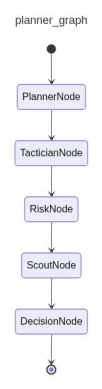

In [39]:
import base64
import io, requests
from IPython.display import Image, display
from PIL import Image as im
import matplotlib.pyplot as plt

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    img = im.open(io.BytesIO(requests.get('https://mermaid.ink/img/' + base64_string).content))
    plt.imshow(img); plt.axis('off') 

mermaid_code = planner_graph.mermaid_code(start_node=PlannerNode)
mm(mermaid_code)

In [ ]:
from __future__ import annotations
from typing import Callable, Dict, List, Optional, Literal, Any, Tuple
from dataclasses import dataclass

from pydantic import BaseModel, Field
from pydantic_ai import Agent
from poke_env.battle.battle import Battle
from poke_env.player.player import Player

from pydantic_graph import BaseNode, End, Graph, GraphRunContext

# ---- (3) Specialist agents (typed) ---------------------------------------------------------------
class PlanCandidate(BaseModel):
    kind: Literal["move", "switch"]
    move_id: Optional[str] = None
    switch_species: Optional[str] = None
    rationale: str
    risk: float = Field(ge=0, le=1)
    value: float

class Plan(BaseModel):
    candidates: List[PlanCandidate]

class EvalScore(BaseModel):
    candidate: PlanCandidate
    score: float
    notes: Optional[str] = None

# Planner: propose 2-4 legal options
planner_agent = Agent(
    model="openrouter:openai/gpt-4o-mini",
    system_prompt=(
        "You propose 2-4 legal actions for the given Pokémon battle context. "
        "Prefer super-effective, high-accuracy moves; consider switches if HP is low or risk is high. "
        "Do NOT invent illegal actions."
    ),
    result_type=Plan,
)

# Tactician: maximize value (damage/tempo)
tactician_agent = Agent(
    model="openrouter:openai/gpt-4o-mini",
    system_prompt="Score each candidate 0..1 for expected value (damage + board advantage).",
    result_type=List[EvalScore],
)

# Risk Officer: minimize KO risk / bad trades
risk_agent = Agent(
    model="openrouter:openai/gpt-4o-mini",
    system_prompt="Score each candidate 0..1 for safety (higher = safer; avoid KO risks).",
    result_type=List[EvalScore],
)

# Scout: prefer information gain
scout_agent = Agent(
    model="openrouter:openai/gpt-4o-mini",
    system_prompt="Score each candidate 0..1 for information gain (forcing reveals, checks).",
    result_type=List[EvalScore],
)

# ---- (4) Coordinator node (routing logic) --------------------------------------------------------
class CoordinatorOut(BaseModel):
    plan: Plan
    run_tactician: bool
    run_risk: bool
    run_scout: bool
    reason: str

def _estimate_danger(ctx) -> float:
    # Heuristic danger signal: few legal moves or low HP on active mon increases danger
    few_moves = (len(ctx.legal_moves) <= 1)
    low_hp = False
    for m in ctx.you_team:
        if m.species == ctx.you_active and m.hp is not None and m.hp < 0.35:
            low_hp = True
            break
    return 0.2 + (0.5 if few_moves else 0.0) + (0.3 if low_hp else 0.0)

def coordinator(ctx_json: str) -> CoordinatorOut:
    # Parse back to structured context (string → dict → model) for robust prompting
    from pydantic import TypeAdapter
    ctx = TypeAdapter(dict).validate_json(ctx_json)

    # Run planner on the stringified context to avoid token bloat
    plan = planner_agent.run_sync(ctx_json).output

    danger = _estimate_danger(AgentContext.model_validate(ctx))
    run_tact = True
    run_risk = danger >= 0.6
    run_scout = AgentContext.model_validate(ctx).turn % 3 == 0  # periodic exploration

    return CoordinatorOut(
        plan=plan,
        run_tactician=run_tact,
        run_risk=run_risk,
        run_scout=run_scout,
        reason=f"danger={danger:.2f}, scout_every_3={run_scout}",
    )

CoordinatorNode = PGNode(coordinator, name="Coordinator")

# ---- (5) Specialist nodes + Arbiter --------------------------------------------------------------
def tactician(ctx_json: str, plan: Plan) -> List[EvalScore]:
    return tactician_agent.run_sync({"ctx": ctx_json, "plan": plan.model_dump()}, structured=False).output

def risk_officer(ctx_json: str, plan: Plan) -> List[EvalScore]:
    return risk_agent.run_sync({"ctx": ctx_json, "plan": plan.model_dump()}, structured=False).output

def scout(ctx_json: str, plan: Plan) -> List[EvalScore]:
    return scout_agent.run_sync({"ctx": ctx_json, "plan": plan.model_dump()}, structured=False).output

TacticianNode = PGNode(tactician, name="Tactician")
RiskNode = PGNode(risk_officer, name="RiskOfficer")
ScoutNode = PGNode(scout, name="Scout")

def arbiter(scores: List[List[EvalScore]]) -> PlanCandidate:
    # Weighted sum (tactician=1.0, risk=0.8, scout=0.4) for simplicity
    weights = [1.0, 0.8, 0.4][: len(scores)]
    tally: Dict[Tuple[str, str], float] = {}
    by_key: Dict[Tuple[str, str], PlanCandidate] = {}

    for w, bucket in zip(weights, scores):
        for s in bucket:
            key = (s.candidate.kind, s.candidate.move_id or s.candidate.switch_species or "NA")
            tally[key] = tally.get(key, 0.0) + w * float(s.score)
            by_key.setdefault(key, s.candidate)

    best_key = max(tally, key=tally.get)
    return by_key[best_key]

ArbiterNode = PGNode(arbiter, name="Arbiter")

# ---- (6) Graph runner (manager orchestration) ----------------------------------------------------
def manager_entry(ctx_json: str) -> Dict[str, Any]:
    # Coordinator decides routing
    co = CoordinatorNode(ctx_json=ctx_json)

    # Collect specialist scores conditionally
    score_buckets: List[List[EvalScore]] = []
    if co.run_tactician:
        score_buckets.append(TacticianNode(ctx_json=ctx_json, plan=co.plan))
    if co.run_risk:
        score_buckets.append(RiskNode(ctx_json=ctx_json, plan=co.plan))
    if co.run_scout:
        score_buckets.append(ScoutNode(ctx_json=ctx_json, plan=co.plan))

    best = ArbiterNode(scores=score_buckets)
    return {"plan": co.plan, "routing": co.model_dump(), "winner": best}

ManagerGraph = PGGraph(name="ManagerialGraph")

# ---- (7) Player wrapper that uses the ManagerGraph -----------------------------------------------
class PydanticGraphManagerPlayer(Player):
    def __init__(self, name: str, **kwargs):
        super().__init__(**kwargs)
        self.name = name
        self._past_actions: List[str] = []

    def _map_decision(self, battle: Battle, cand: PlanCandidate, turn: int, you_active: str, opp_active: str):
        if cand.kind == "move":
            for m in battle.available_moves:
                if m.id == (cand.move_id or ""):
                    self._past_actions.append(f"T{turn}: MOVE {cand.move_id} ({you_active} vs {opp_active})")
                    return self.create_order(m)
        else:
            for p in battle.available_switches:
                if p.species == (cand.switch_species or ""):
                    self._past_actions.append(f"T{turn}: SWITCH to {cand.switch_species} (from {you_active})")
                    return self.create_order(p)
        self._past_actions.append(f"T{turn}: FALLBACK random (no legal match)")
        return self.choose_random_move(battle)

    def choose_move(self, battle: Battle):
        ctx = build_context(battle, past_actions=self._past_actions)
        ctx_json = agent_context_to_string(ctx)

        out = ManagerGraph.run(entry=manager_entry, ctx_json=ctx_json)
        winner: PlanCandidate = out["winner"]

        return self._map_decision(
            battle=battle,
            cand=winner,
            turn=ctx.turn,
            you_active=ctx.you_active or "Unknown",
            opp_active=ctx.opp_active or "Unknown",
        )

# Usage (example):
# mgr_player = PydanticGraphManagerPlayer(name="ManagerAgent", battle_format="gen8randombattle")
# await mgr_player.battle_against(RandomPlayer(battle_format="gen8randombattle"), n_battles=1)
